In [15]:
from helpers.log_config import setup_logging
setup_logging()

import numpy as np
import pandas as pd
from swmm_api.output_file.extract import SwmmOutExtractWarning
import warnings
from apps.blockage_sim import sim_blockage
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=SwmmOutExtractWarning)

# Input Data
## Input files
please insert model- and output-paths here

In [16]:
# model input and output files
model_path = r"..\sample_data\simple_model.inp"
out_path = r"..\sample_data\simple_model.out"
# population data
pop_path = r"../sample_data/pop_data_simple.csv"
df_population = pd.read_csv(pop_path)

## Input patterns
define the defecation pattern / how many flushes containing wipes per hour are usually done
and define how many wipes are usually flushed per event

In [4]:
# pattern for distribution of defecation events, total sum of 1.5 defecations per day
df_defpat = pd.Series(1.5 * np.array([1.4, 0.3, 0.1, 0.0, 0.3, 1.7, 9.1, 21, 13, 9, 6.9, 4.9,
                                     1.9, 3.6, 2.5, 2, 2.9, 2.3, 4.1, 4.0, 2.7, 2.1, 2.2, 2.0])/100)
# number of wipes sent per flush
wipes_per_flush = 5

## Snagging function
define the function that determines with what probability a packet snags depending on the velocity in the pipe

In [5]:
probability_by_velocity = lambda v: 0.1

## Blocking function
Define the blockage / opening of conduit depending on pile size

create a function that returns the target setting of a conduit depending on the number of snagged wipes 

In [6]:
blockage_from_pile = lambda pile: (pile / (2+pile))

## Simulation settings
define the node of interest at which snagging occurs
define the decay rate of the pile
define how often the simulation should be updated with the next pile size and blockage setting

In [7]:
target_node = "MH3329503824",
decay_rate = lambda flow, pile, hour: 0.1
pile_decay_rate = decay_rate,  # 1/hr
update_freq = "10H"

# Runner
This cell runs the model, interrupts in defined intervals, reads output data and adapts the model parameters

In [8]:
# combines all information into a dict to pass as an argument
simulation_dict = dict(
    model_path=model_path,
    out_path=out_path,
    pop_path=pop_path,
    defpat=df_defpat,
    wipes_per_flush=wipes_per_flush,
    probability_by_velocity=probability_by_velocity,
    blockage_from_pile=blockage_from_pile,
    target_node = "MH3295504178",
    pile_decay_rate = 0.1,  # 1/hr
    update_freq = "10H"
)

In [13]:
# run blockage simulation
sim_blockage(**simulation_dict)

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

# Evaluation

In [10]:
from swmm_api import read_out_file
from swmm_api.output_file import VARIABLES as swmm_vars
from swmm_api.output_file import OBJECTS as swmm_objs

## get pile size over time

In [50]:
out = read_out_file(out_path)
df_flows = out.get_part(kind=swmm_objs.LINK, variable=swmm_vars.LINK.FLOW)
df_velocities = out.get_part(kind=swmm_objs.LINK, variable=swmm_vars.LINK.VELOCITY)

Text(0, 0.5, 'flow rate [L/s]')

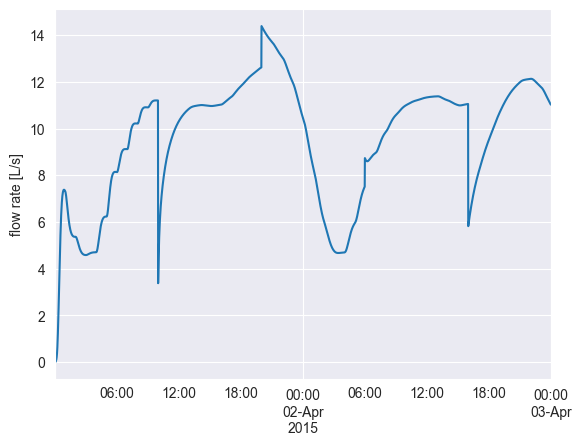

In [51]:
fig, ax = plt.subplots()
df_flows["MH3295504178.1"].plot(label="flow rate", ax=ax)
ax.set_ylabel("flow rate [L/s]")
# ax2 = ax.twinx()
# df_velocities["MH3295504178.1"].plot(label="velocities", ax=ax2)
# ax2.set_ylabel("velocities [m/s]")

(16526.000694444443, 16528.0)

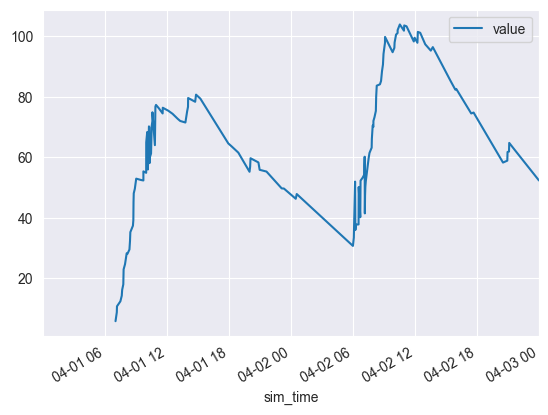

In [52]:
columns = ["log_time", "logger", "level", "sim_time", "variable", "value"]
df_log = pd.read_csv(r"../helpers/application.log", sep=";", skiprows=15)
df_log.columns = columns
# df_log["log_time"] = pd.to_datetime(df_log["log_time"])
df_pile_size = df_log.loc[df_log["variable"]=="pile size", ["sim_time", "value"]]
df_pile_size["sim_time"] = pd.to_datetime(df_pile_size["sim_time"])

fig, ax = plt.subplots()
df_pile_size.set_index("sim_time").plot(ax=ax)
ax.set_xlim([df_flows.index[0], df_flows.index[-1]])

In [42]:
df_flows.index[-1]

Timestamp('2015-04-02 16:00:00', freq='T')